<a href="https://colab.research.google.com/github/andrewjcoxon/Hands-On-Data-Science-with-Anaconda/blob/master/8_zero_to_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu
!pip install gdown

     |████████████████████████████████| 320.4MB 47kB/s 
     |████████████████████████████████| 6.8MB 13.6MB/s 
     |████████████████████████████████| 460kB 31.5MB/s 
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.3.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 2.3.0 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import joblib

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!gdown --id 1aRXGcJlIkuC6uj1iLqzi9DQQS-3GPwM_ --output airbnb_nyc.csv

Downloading...
From: https://drive.google.com/uc?id=1aRXGcJlIkuC6uj1iLqzi9DQQS-3GPwM_
To: /content/airbnb_nyc.csv
7.08MB [00:00, 22.5MB/s]


In [4]:
df = pd.read_csv('airbnb_nyc.csv')

# Exploration

In [5]:
df.shape

(48895, 16)

In [6]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

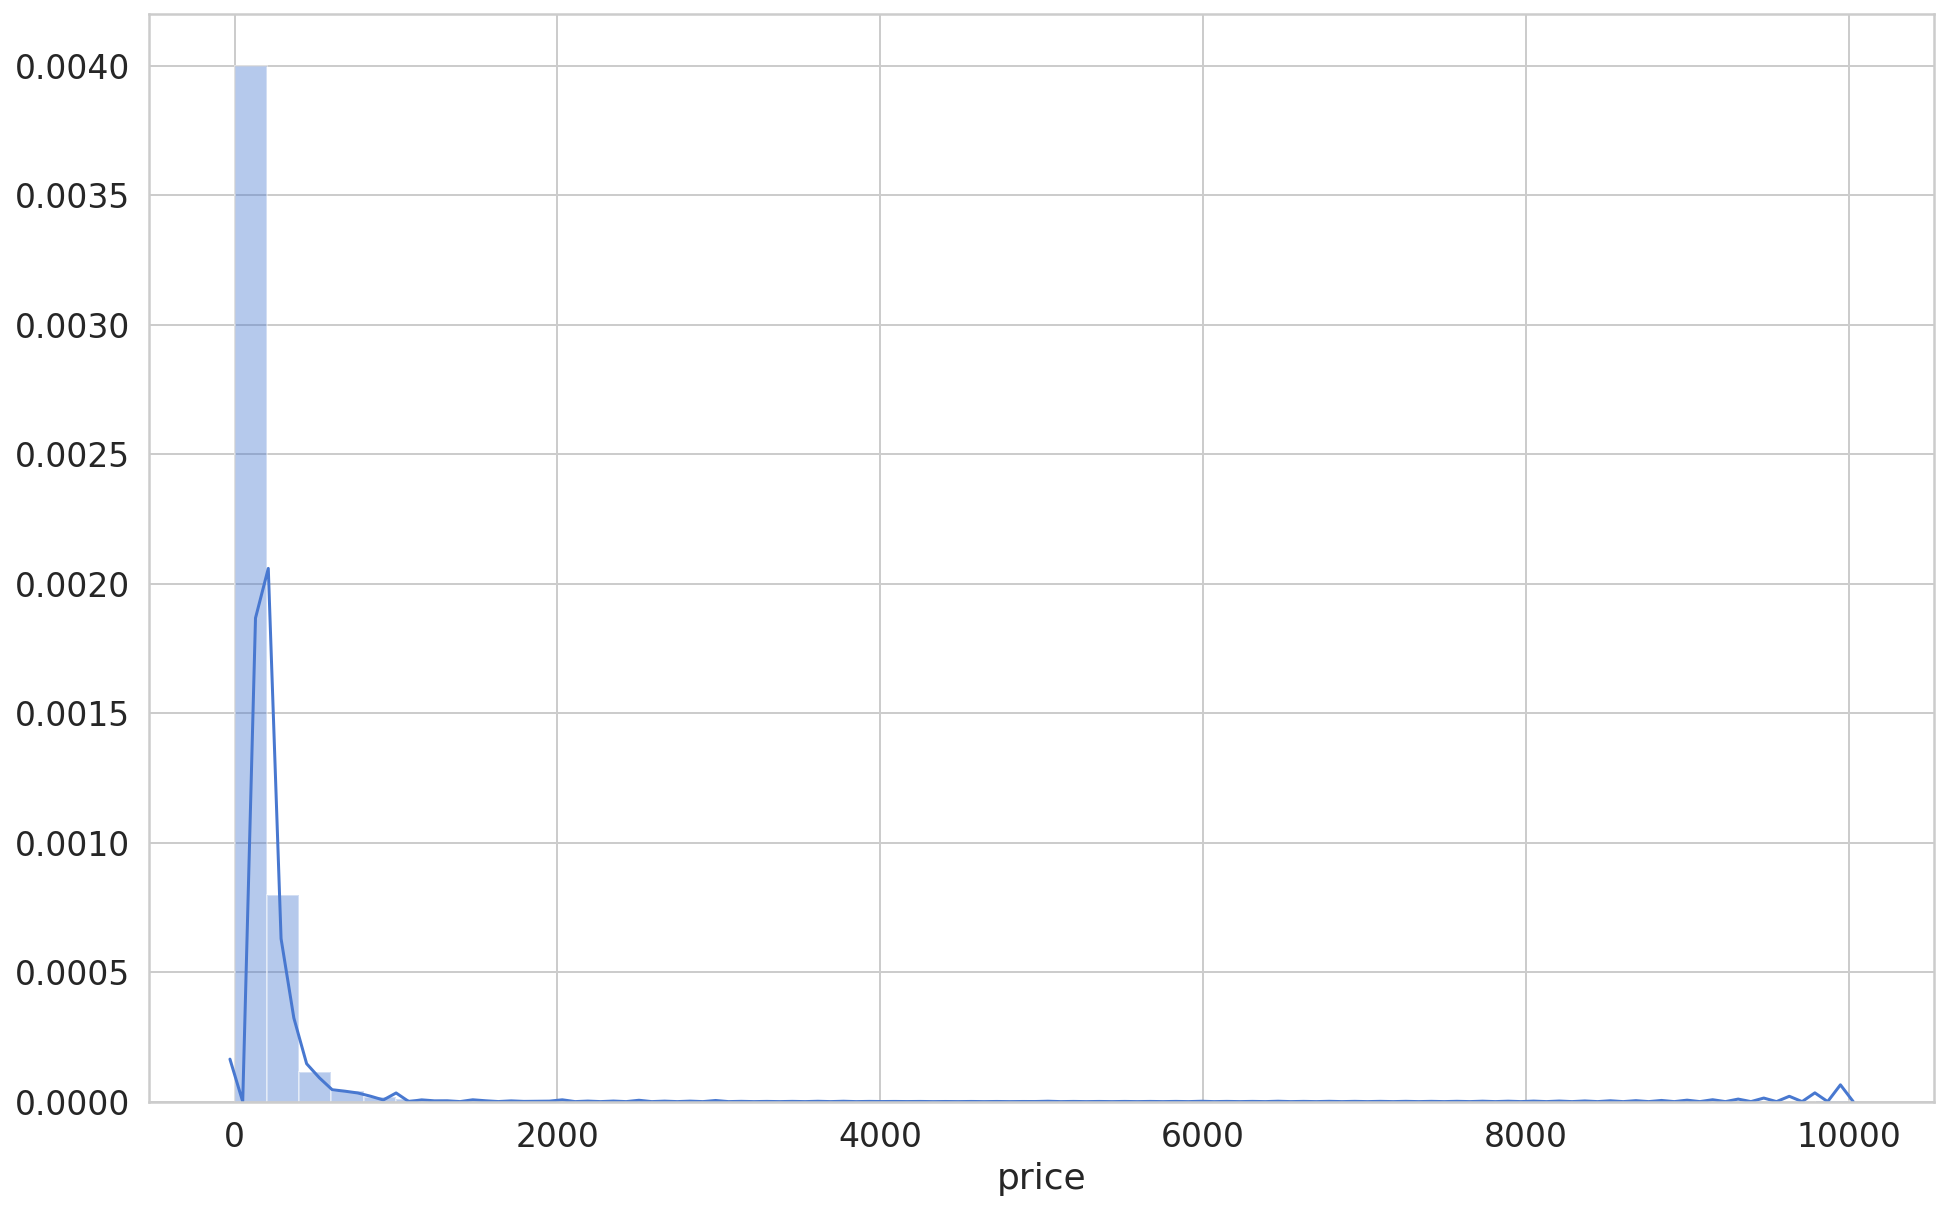

In [7]:
sns.distplot(df.price);

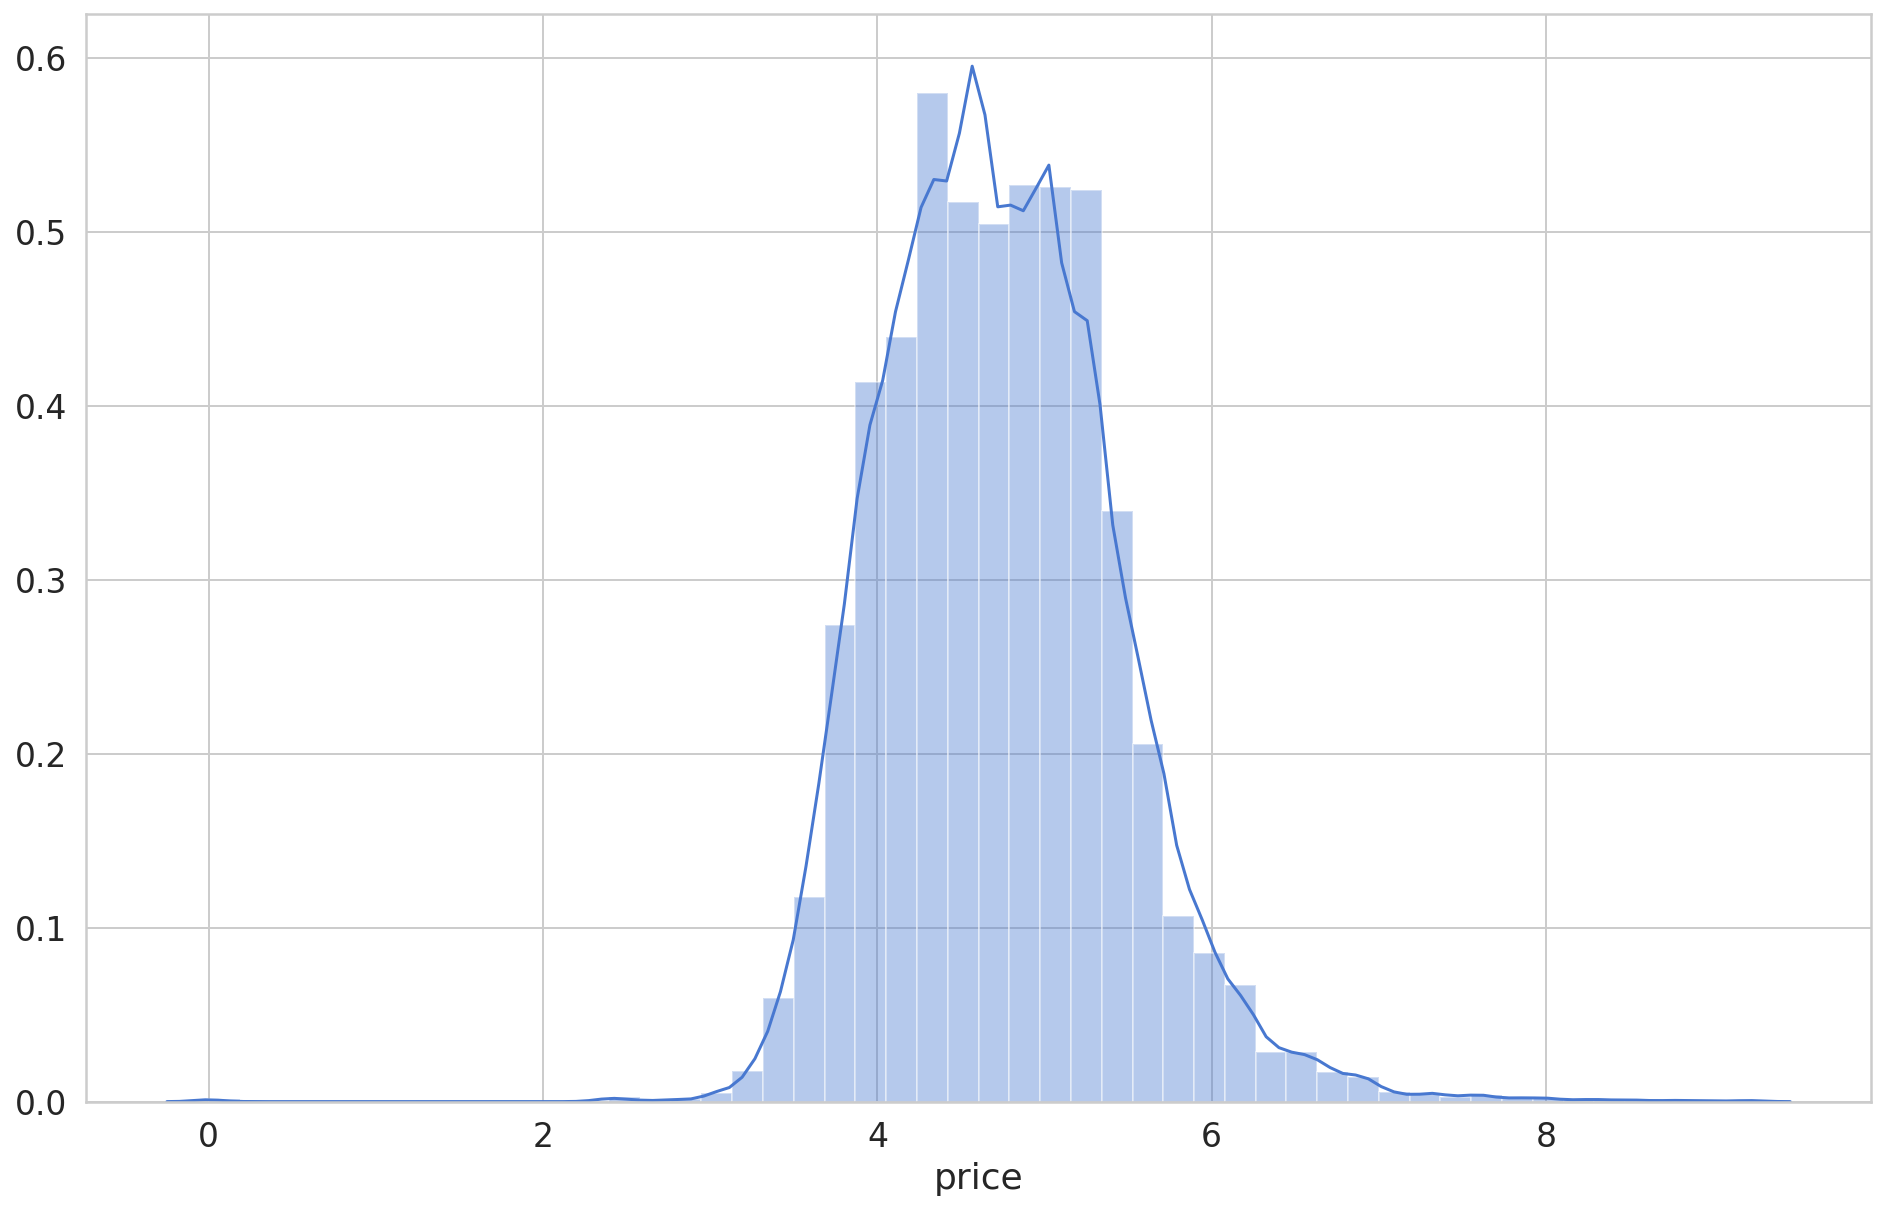

In [8]:
sns.distplot(np.log1p(df.price));

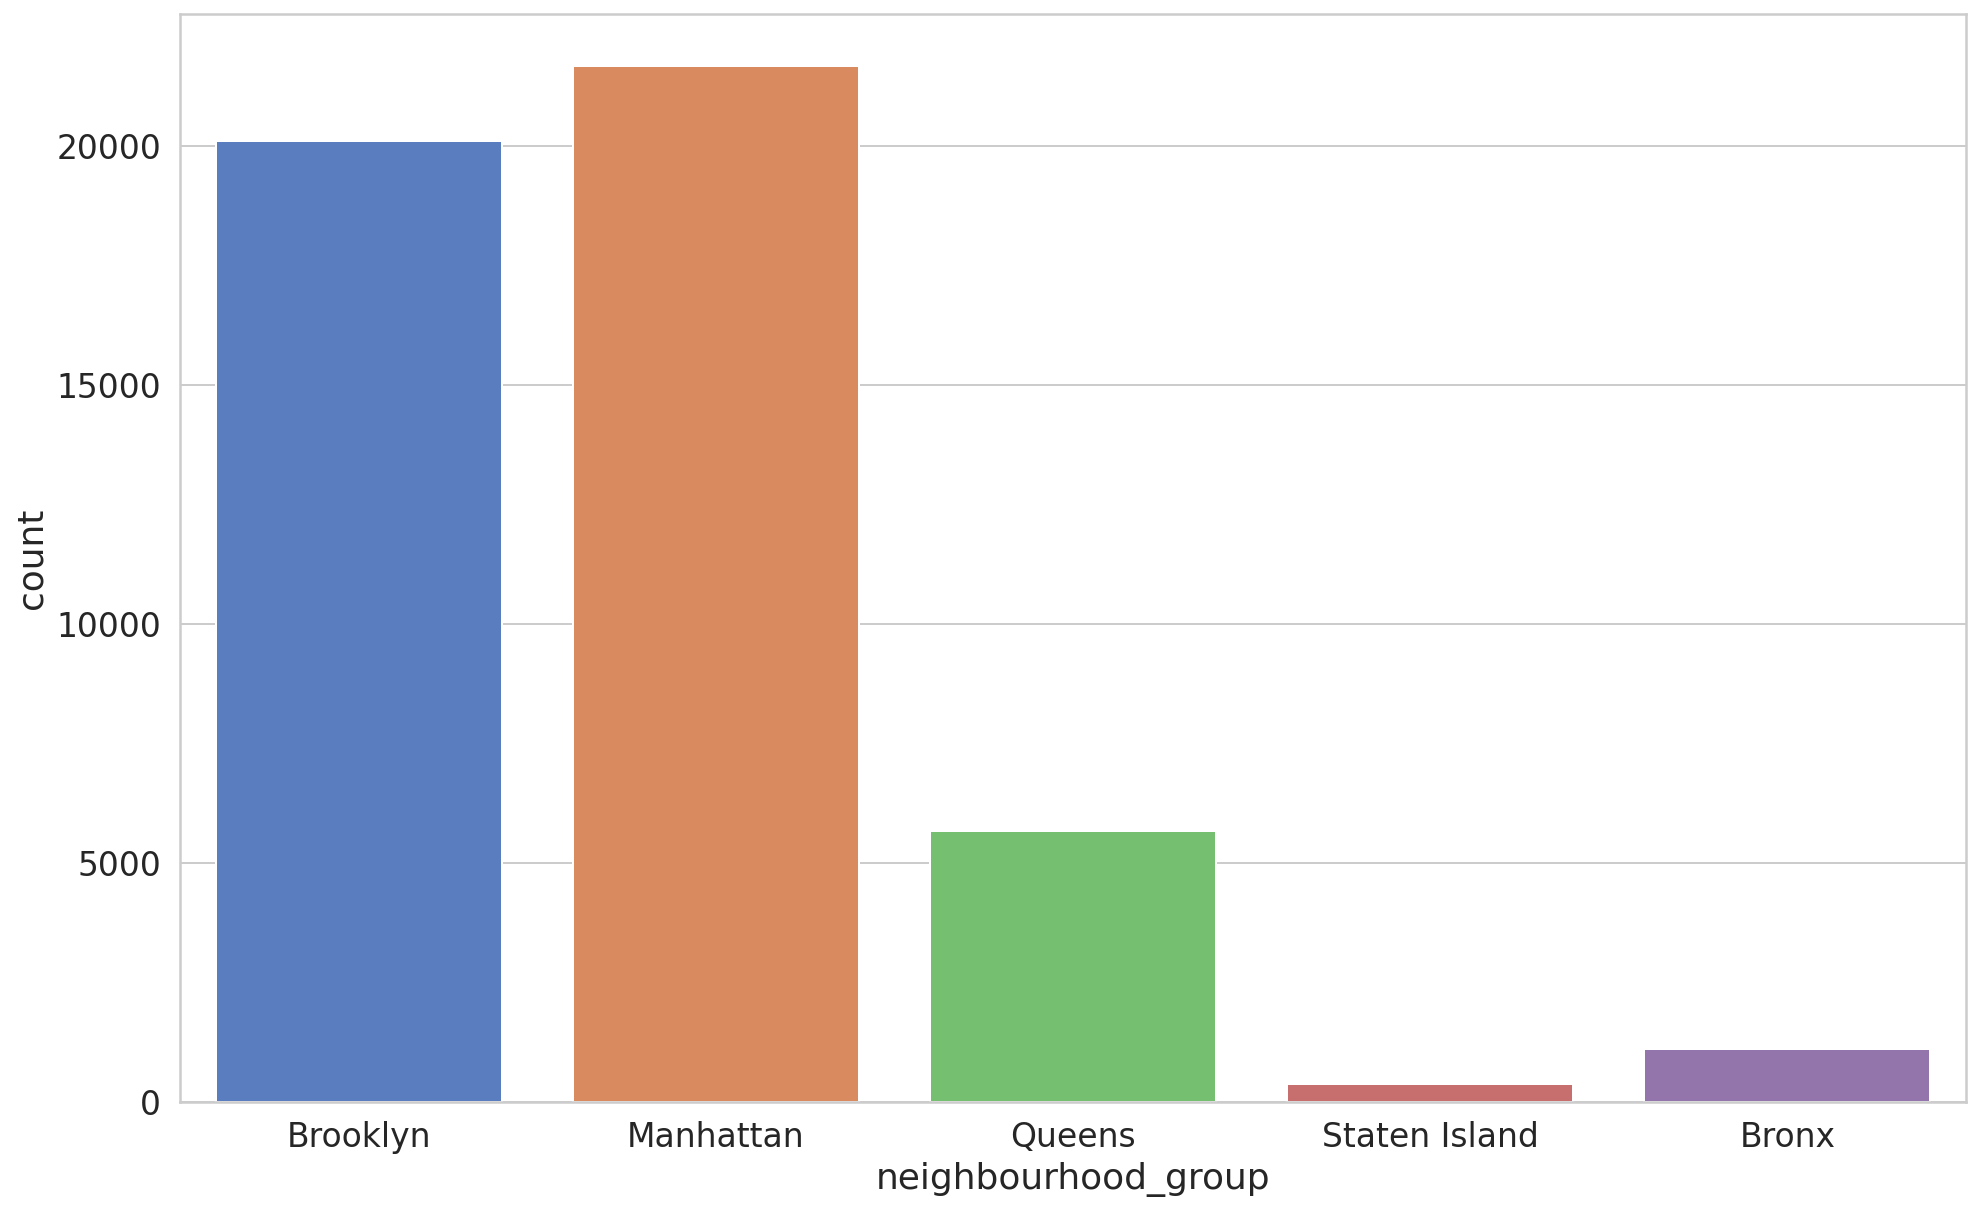

In [9]:
sns.countplot(x='neighbourhood_group', data=df);

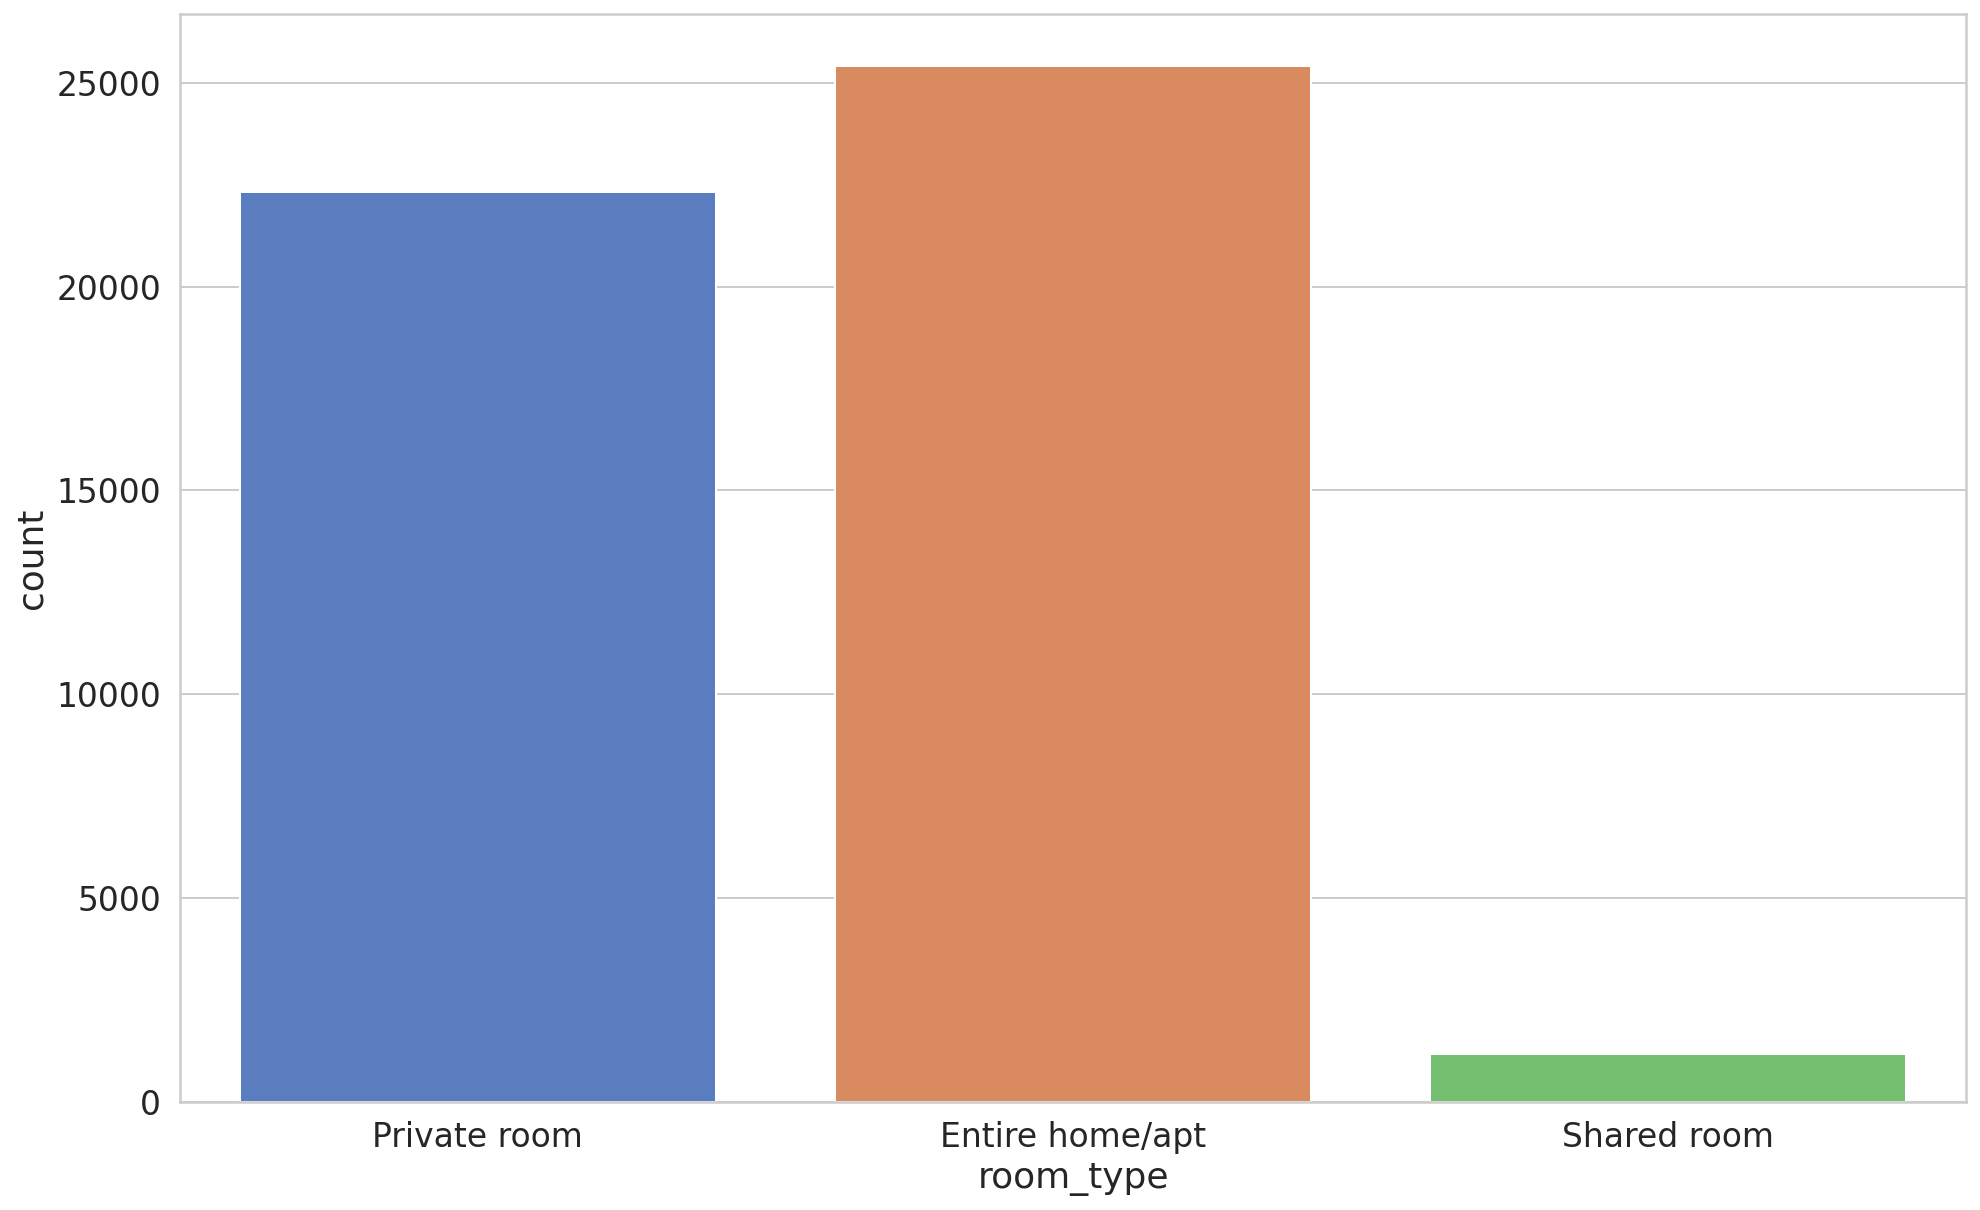

In [10]:
sns.countplot(x='room_type', data=df);

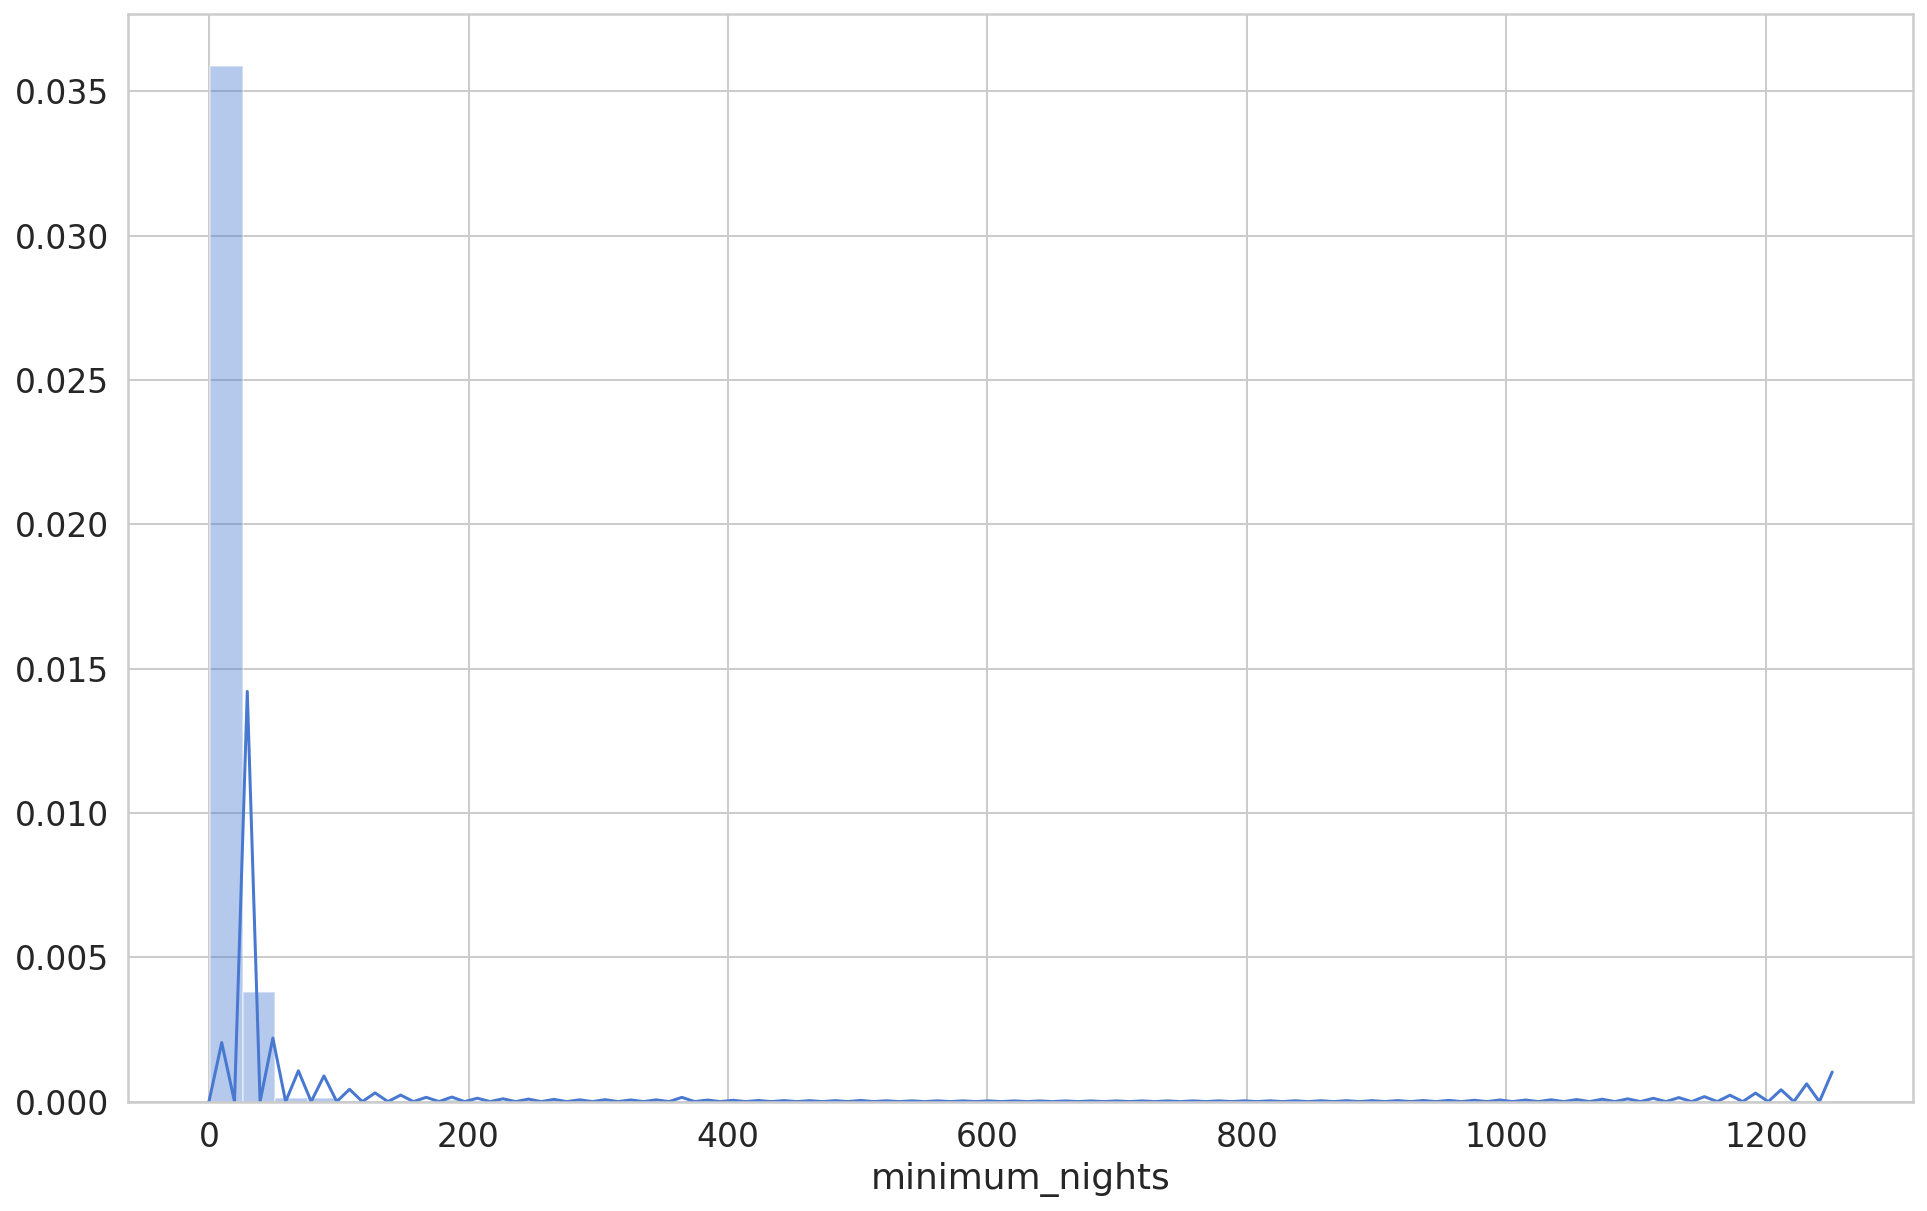

In [11]:
sns.distplot(df.minimum_nights);

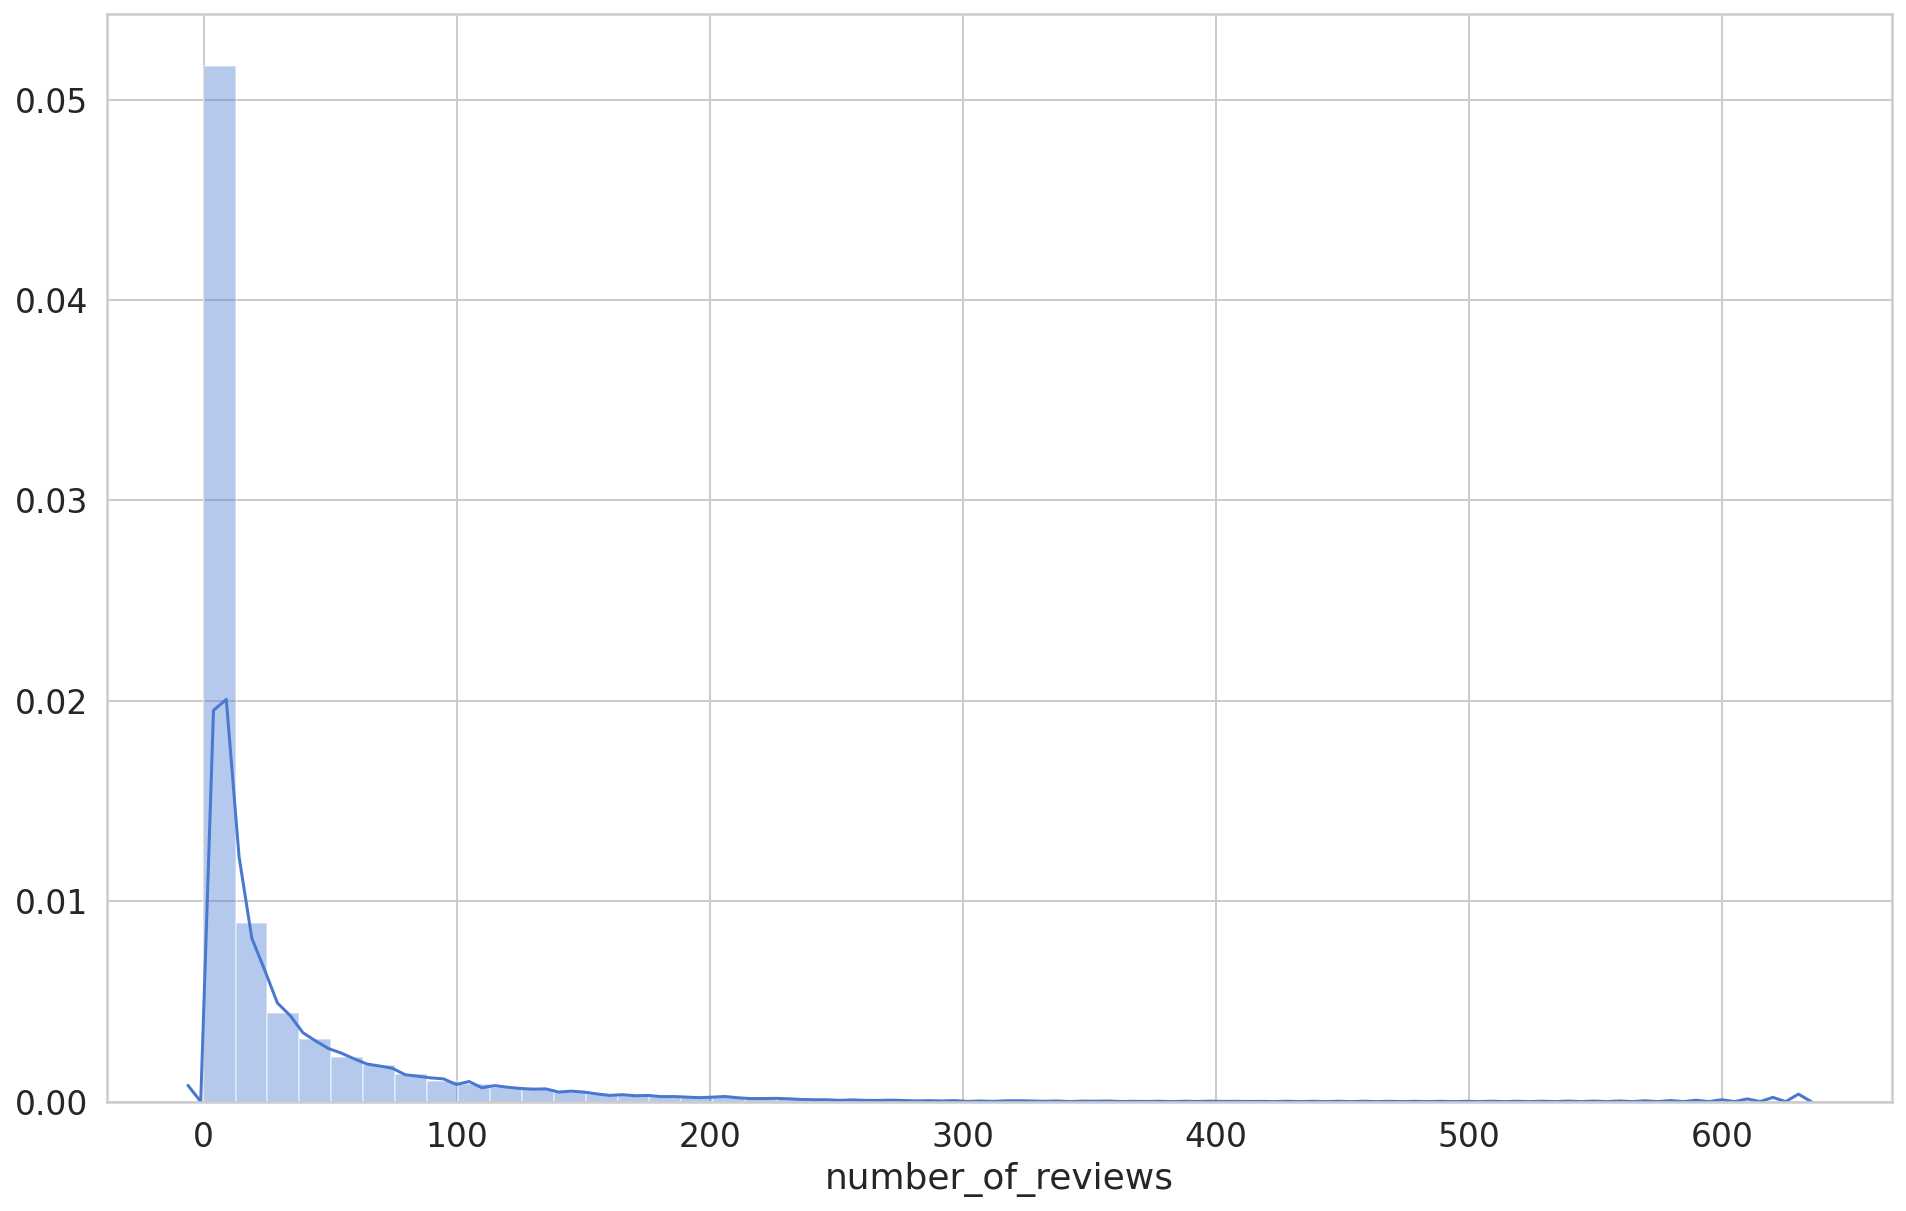

In [12]:
sns.distplot(df.number_of_reviews);

In [13]:
corr_matrix = df.corr()

In [14]:
price_corr = corr_matrix['price']
price_corr.iloc[price_corr.abs().argsort()]

id                                0.010619
host_id                           0.015309
reviews_per_month                -0.030608
latitude                          0.033939
minimum_nights                    0.042799
number_of_reviews                -0.047954
calculated_host_listings_count    0.057472
availability_365                  0.081829
longitude                        -0.150019
price                             1.000000
Name: price, dtype: float64

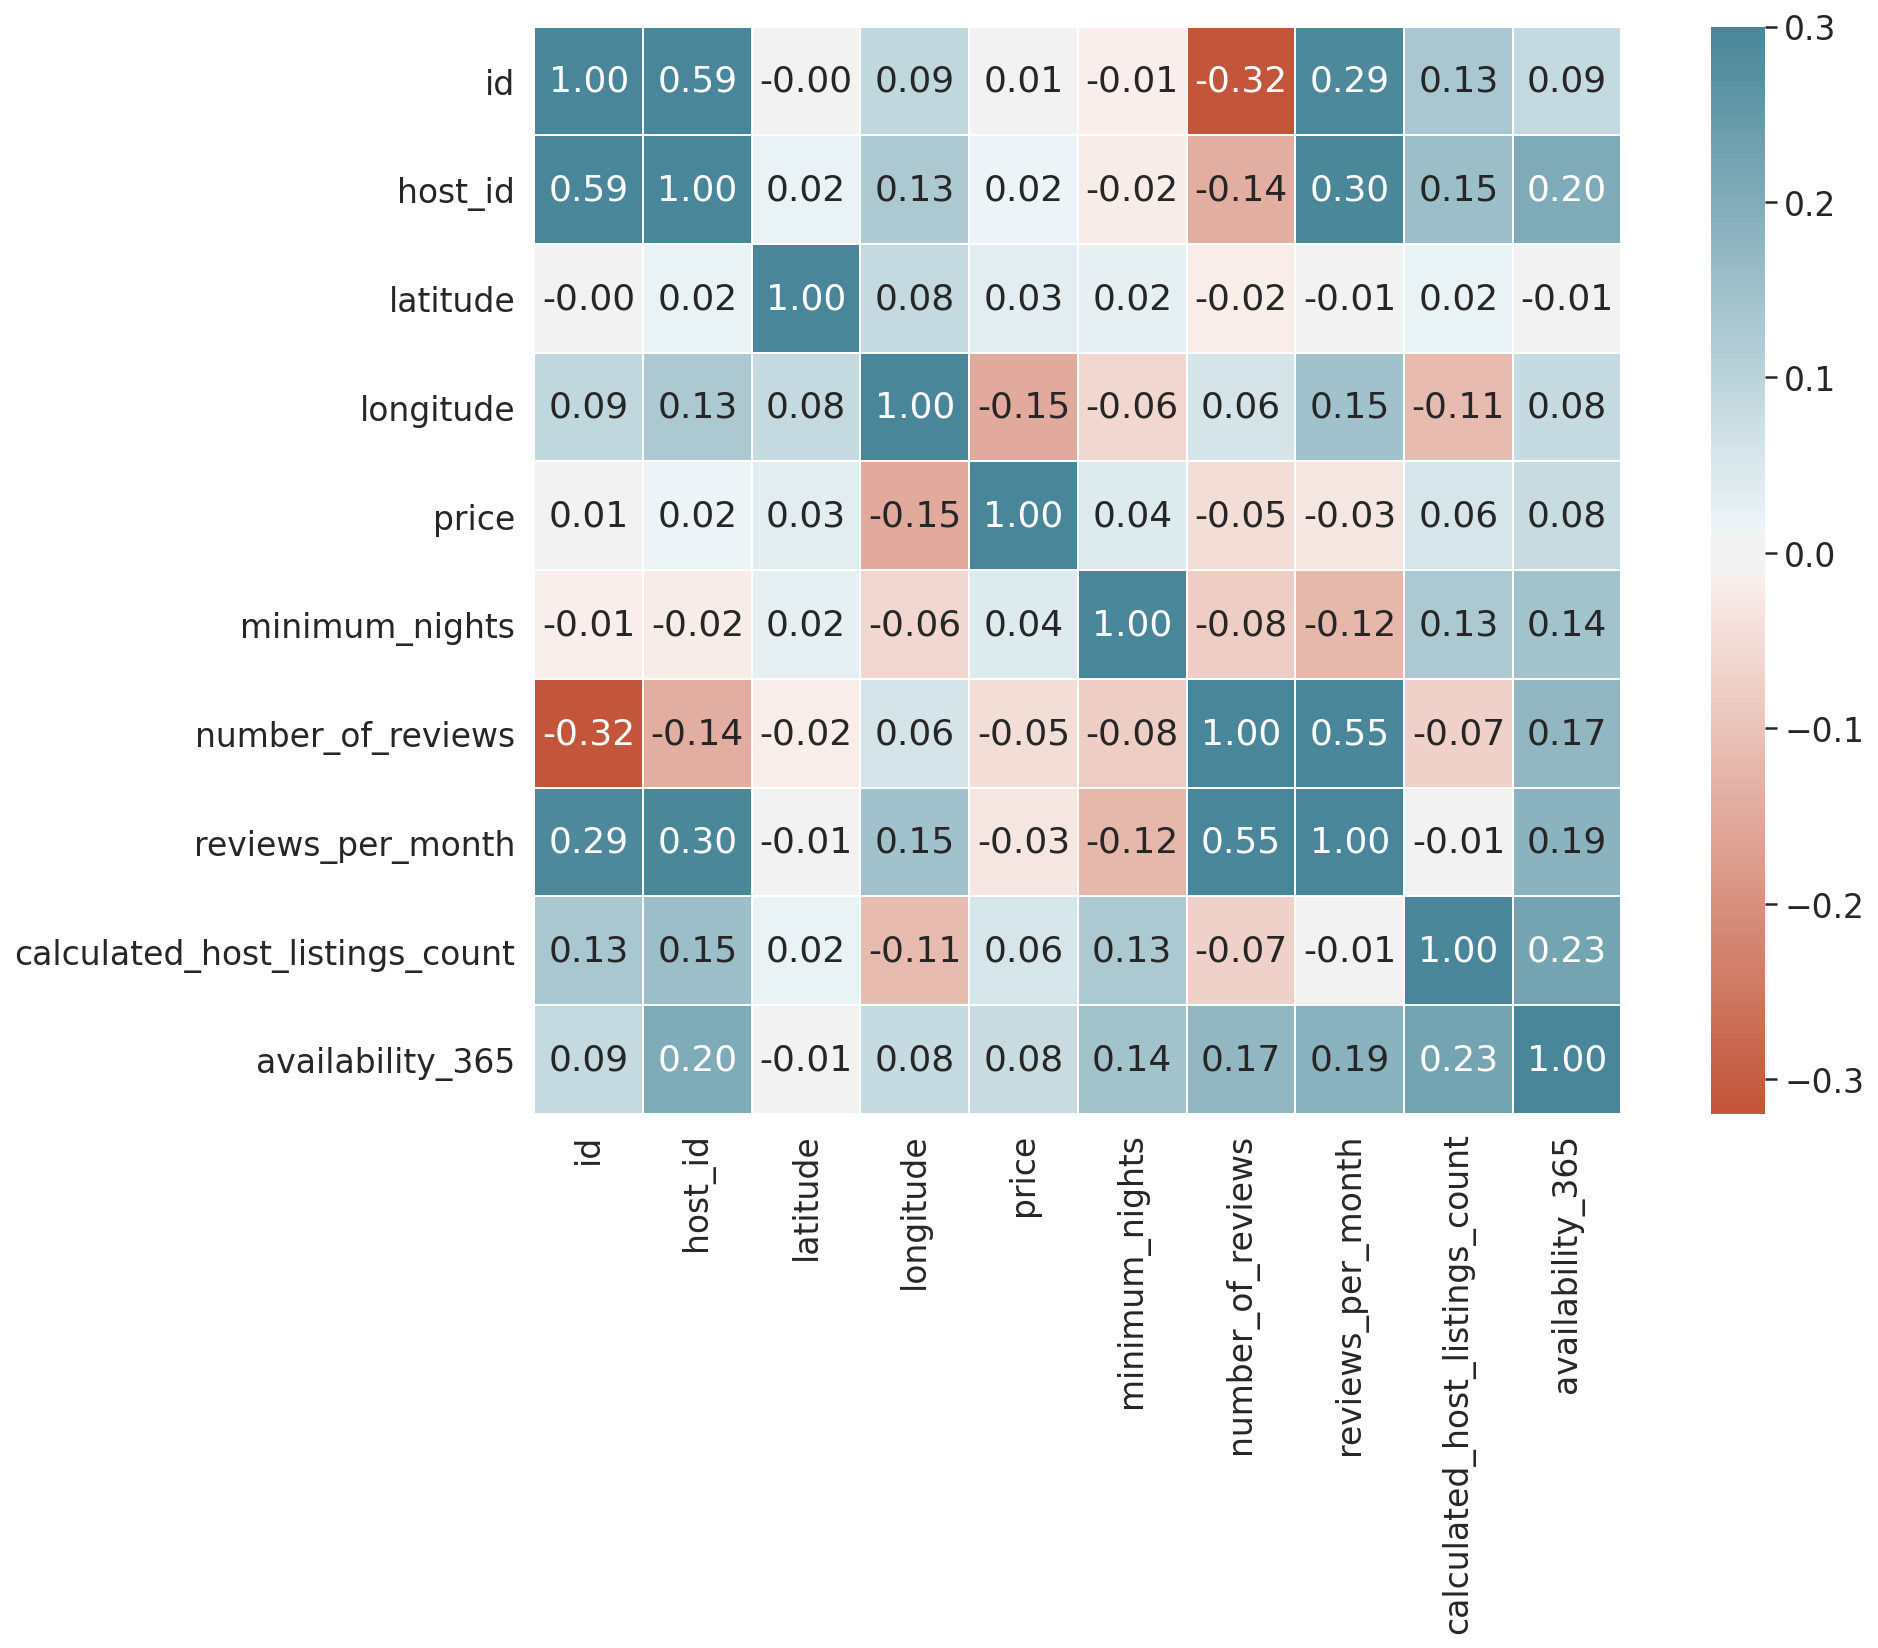

In [15]:
palette = sns.diverging_palette(20, 220, n=256)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5);

# Preprocessing




## Missing data?

In [17]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

reviews_per_month    10052
last_review          10052
host_name               21
name                    16
dtype: int64

## Remove unused columns!


In [18]:
df = df.drop(['id', 'name', 'host_id', 'host_name', 'reviews_per_month', 'last_review', 'neighbourhood'], axis=1)

In [ ]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

In [20]:
df.columns

Index(['neighbourhood_group', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [21]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


## Predict log1p

In [22]:
X = df.drop('price', axis=1)
y = np.log1p(df.price.values)

## Feature scaling and One-hot encoding

In [23]:
from sklearn.preprocessing import OneHotEncoder

data = [['Manhattan'], ['Brooklyn']]

OneHotEncoder(sparse=False).fit_transform(data)

array([[0., 1.],
       [1., 0.]])

In [24]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    (MinMaxScaler(), ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365']),
    (OneHotEncoder(handle_unknown="ignore"), ['neighbourhood_group', 'room_type'])
)

In [25]:
transformer.fit(X)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('minmaxscaler',
                                 MinMaxScaler(copy=True, feature_range=(0, 1)),
                                 ['latitude', 'longitude', 'minimum_nights',
                                  'number_of_reviews',
                                  'calculated_host_listings_count',
                                  'availability_365']),
                                ('onehotencoder',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='ignore',
                                               sparse=True),
                                 ['neighbourhood_group', 'room_type'])],
                  verbose=False)

In [26]:
X = transformer.transform(X)

## Split the training and test data

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [28]:
X_train.shape

(39116, 14)

# Modeling

In [29]:
def plot_mse(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.plot(hist['epoch'], hist['mse'],
            label='Train MSE')
  plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Val MSE')
  plt.legend()
  plt.show()

Epoch 1/100
978/978 [==============================] - 3s 3ms/step - loss: 8.7059 - mse: 8.7059 - val_loss: 0.5553 - val_mse: 0.5553
Epoch 2/100
978/978 [==============================] - 3s 3ms/step - loss: 2.3694 - mse: 2.3694 - val_loss: 0.4864 - val_mse: 0.4864
Epoch 3/100
978/978 [==============================] - 3s 3ms/step - loss: 2.0916 - mse: 2.0916 - val_loss: 0.4619 - val_mse: 0.4619
Epoch 4/100
978/978 [==============================] - 3s 3ms/step - loss: 2.0155 - mse: 2.0155 - val_loss: 0.4537 - val_mse: 0.4537
Epoch 5/100
978/978 [==============================] - 4s 4ms/step - loss: 1.9289 - mse: 1.9289 - val_loss: 0.4550 - val_mse: 0.4550
Epoch 6/100
978/978 [==============================] - 4s 4ms/step - loss: 1.8660 - mse: 1.8660 - val_loss: 0.4001 - val_mse: 0.4001
Epoch 7/100
978/978 [==============================] - 4s 4ms/step - loss: 1.7808 - mse: 1.7808 - val_loss: 0.4329 - val_mse: 0.4329
Epoch 8/100
978/978 [==============================] - 3s 3ms/step - 

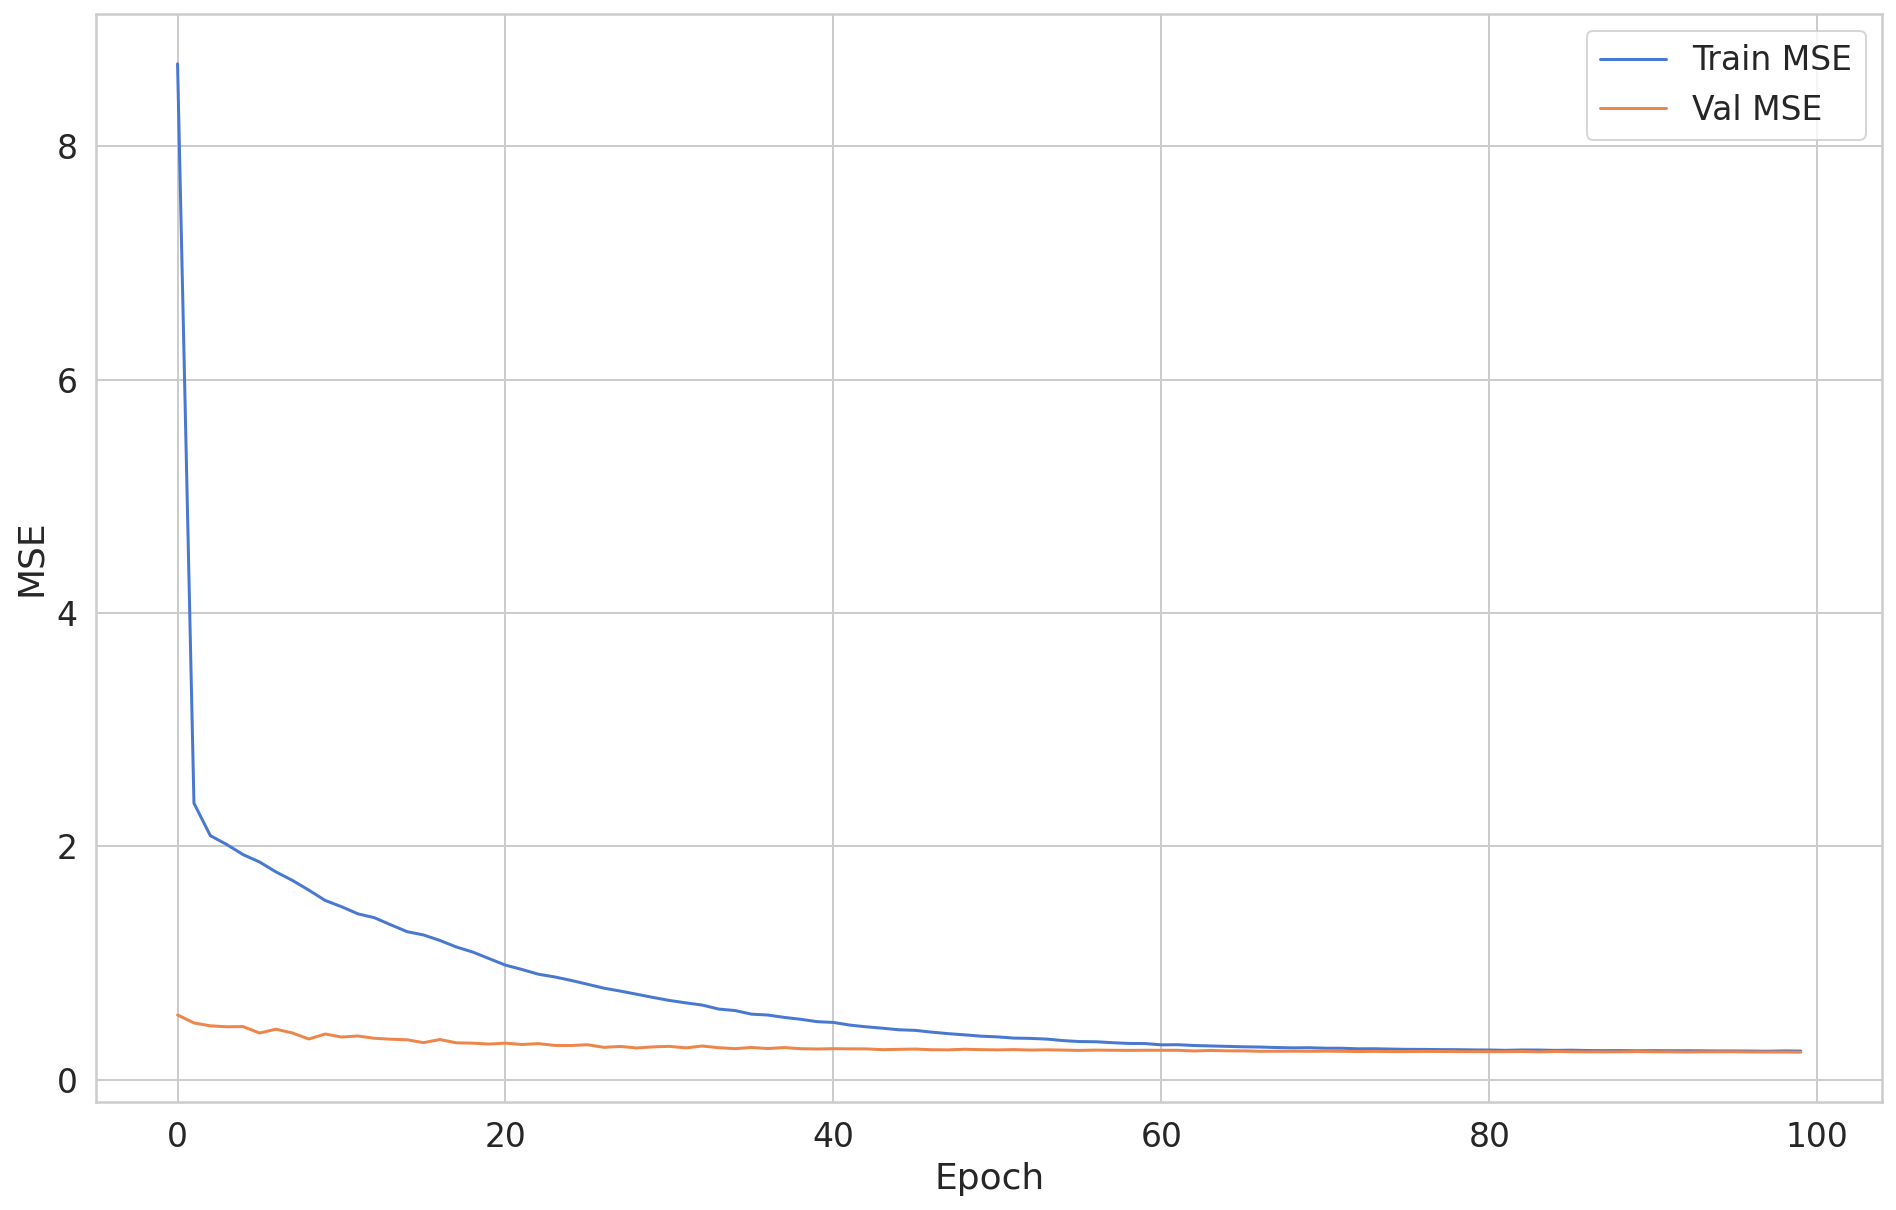

In [30]:
model = keras.Sequential()
model.add(keras.layers.Dense(units=64, activation="relu", input_shape=[X_train.shape[1]]))
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(units=32, activation="relu"))
model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(1))

model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss = 'mse', 
    metrics = ['mse'])

BATCH_SIZE = 32

early_stop = keras.callbacks.EarlyStopping(
  monitor='val_mse',
  mode="min",
  patience=10
)

history = model.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=100,
  validation_split=0.2,
  batch_size=BATCH_SIZE,
  callbacks=[early_stop]
)

plot_mse(history)

# Evaluation

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

In [32]:
y_pred = model.predict(X_test)

In [34]:
f'MSE {mean_squared_error(y_test, y_pred)}'

'MSE 0.21182609106756758'

In [35]:
f'MAE {mean_absolute_error(y_test, y_pred)}'

'MAE 0.33268860168118364'

In [37]:
f'RMSE {np.sqrt(mean_squared_error(y_test, y_pred))}'

'RMSE 0.4602456855501935'

In [38]:
f'R2 {r2_score(y_test, y_pred)}'

'R2 0.552247710401488'

# Saving

In [39]:
joblib.dump(transformer, "data_transformer.joblib")
model.save("price_prediction_model.h5")

In [40]:
from google.colab import files

In [41]:
files.download("data_transformer.joblib")
files.download("price_prediction_model.h5") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>